# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [61]:
import logging
import os
import s3fs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [4]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 64 
pd.set_option('compute.use_numexpr', True)

In [68]:
s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

fs = s3fs.S3FileSystem(anon=False, key=s3_access_key, secret=s3_secret_access_key)

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [5]:
tracks = pd.read_parquet("./tracks.parquet")

In [6]:
catalog_names = pd.read_parquet("./catalog_names.parquet")

In [7]:
interactions = pd.read_parquet("./interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [8]:
tracks.info()
catalog_names.info()
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), i

Пример данных

In [9]:
print(tracks[["track_id", "albums", "artists", "genres"]].sample(5, random_state=52).sort_values("track_id").set_index("track_id").to_string())
print(catalog_names[["id", "type", "name"]].sample(5, random_state=52).sort_values("id").set_index("id").to_string())
print(interactions[["user_id", "track_id", "track_seq", "started_at"]].sample(5, random_state=52).sort_values("user_id").set_index(["user_id", "track_id"]).to_string())

                          albums           artists        genres
track_id                                                        
88957     [8201, 88361, 6045574]            [3543]  [11, 44, 75]
46257838               [6233977]         [4383623]       [3, 75]
48263278      [6575614, 7058305]  [678505, 611169]          [68]
61200248               [9527234]          [915312]          [11]
97110155              [19968185]         [4172355]     [14, 102]
           type                      name
id                                       
87080     album                  El Cielo
4989459   album             Edm Club Hits
9088932   track  Let´s Make A Night Of It
37540174  track                Чертополох
69405644  track             A Lucid Dream
                  track_seq started_at
user_id track_id                      
46179   29544272         37 2022-11-23
70117   28213677       1055 2022-09-18
72819   85090862        270 2022-08-08
471152  55682            18 2022-09-10
688081  220497   

Смотрим на поля

In [10]:
print(tracks.sample(3).T)
print(catalog_names.sample(3).T)
print(interactions.sample(3).T)

                      460950      894839                       457333
track_id            32124004    74300962                     31925695
albums    [3910921, 3936373]  [11385017]  [3880168, 3948238, 4418864]
artists               [7099]          []                     [215043]
genres                  [11]    [62, 77]                         [16]
       187391                     1696449    407814 
id     2963816                   72822690    7673908
type     album                      track      album
name  Elements  Another Day To Go Nowhere  Paciencia
                           18                   2311                 1254
user_id                    2514               795565               679264
track_id                 609668             64015813             85707865
track_seq                    19                 2312                 1255
started_at  2022-09-25 00:00:00  2022-10-13 00:00:00  2022-12-14 00:00:00


Кол-во уникальных значений

In [11]:
print("Треки - ", tracks["track_id"].nunique())
print("Названия - ", catalog_names["id"].nunique())
print("Взаимодействия - ", interactions["user_id"].nunique())

Треки -  1000000
Названия -  1776697
Взаимодействия -  1373221


In [12]:
# Вычищаем треки с неизвесными исполнителями, альбомами, жанрами
# print(tracks.query("albums IN (1728221, 1728222)"))
unknown_ids = tracks[(tracks.artists.str.len() == 0) | (tracks.albums.str.len() == 0) | (tracks.genres.str.len() == 0)]["track_id"].to_list()
tracks = tracks.query("track_id != @unknown_ids").copy()

print(tracks["track_id"].nunique())

980977


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

Присутствовали данные без исполнителей или альбомов или жанров
Такие данные нам не подойдут для обучения, они вычищены из датасета

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


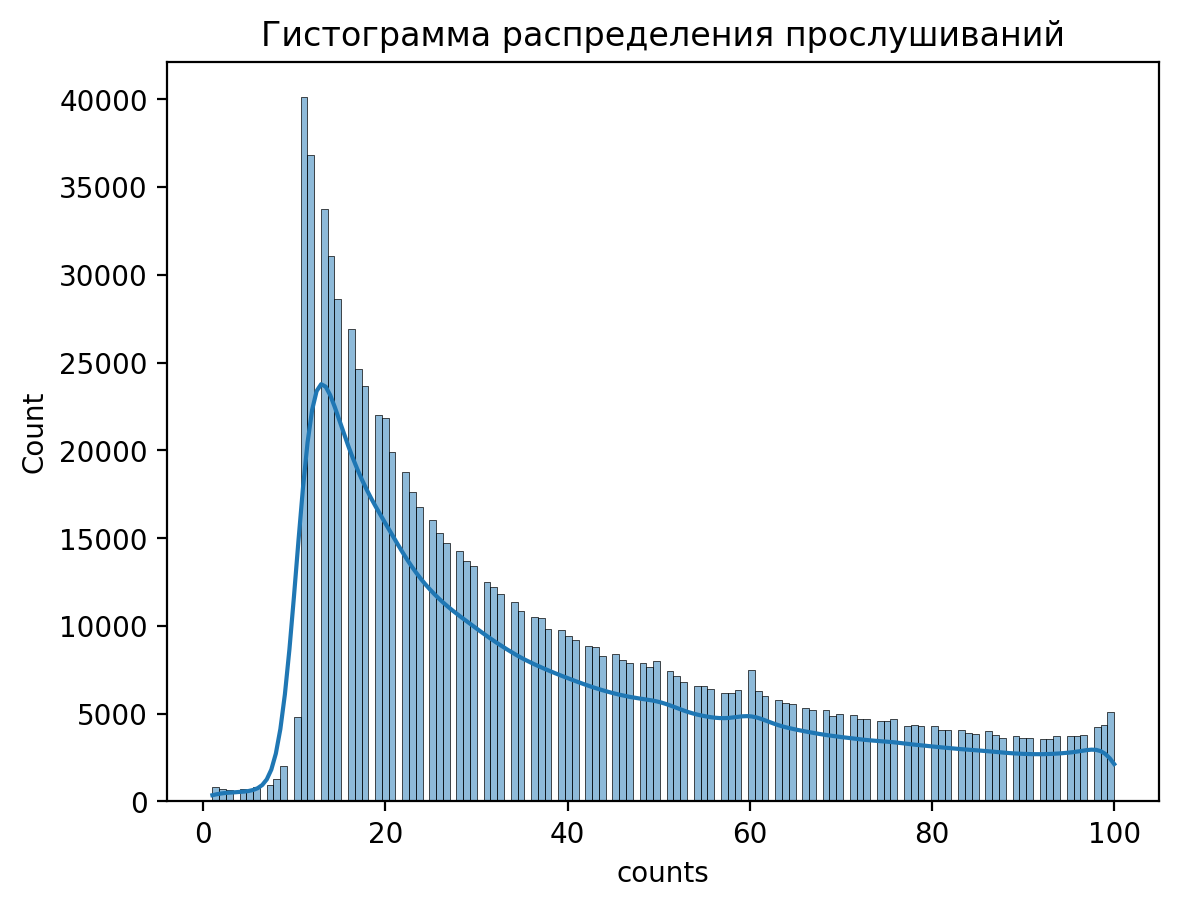

In [24]:
interactions_counts = interactions \
    .groupby(["user_id"]).agg(counts=("track_id", "count")).reset_index()
# print(df.query("counts < 50"))
df = interactions_counts.query("counts <= 100").copy()
sns.histplot(data=df, x="counts", kde=True)
plt.title('Гистограмма распределения прослушиваний')
plt.show()

/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


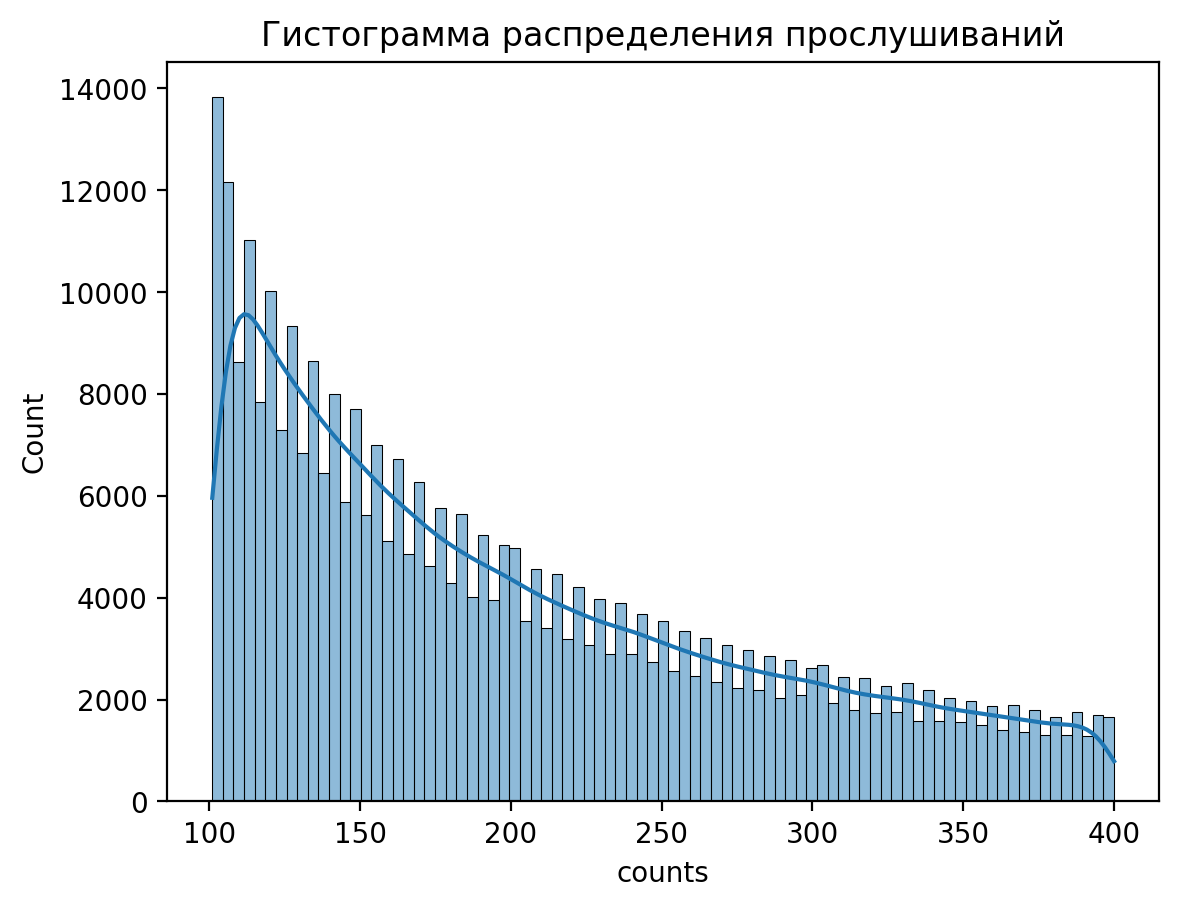

In [31]:
df = interactions_counts.query("counts > 100 & counts <= 400").copy()
sns.histplot(data=df, x="counts", kde=True)
plt.title('Гистограмма распределения прослушиваний')
plt.show()

/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


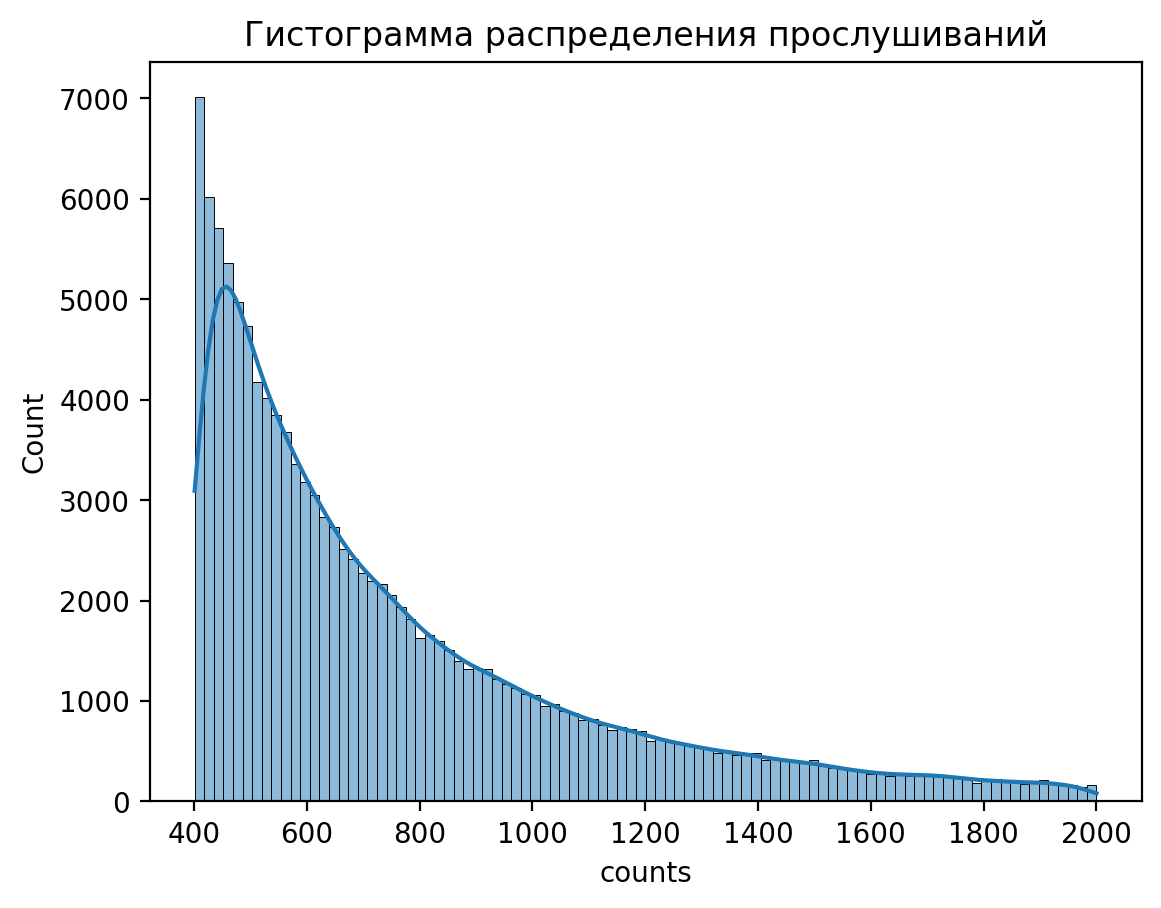

In [32]:
df = interactions_counts.query("counts > 400 & counts <= 2000").copy()
sns.histplot(data=df, x="counts", kde=True)
plt.title('Гистограмма распределения прослушиваний')
plt.show()

/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mle-user/mle_projects/mle-recsys-project-start/.venv_recsys_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


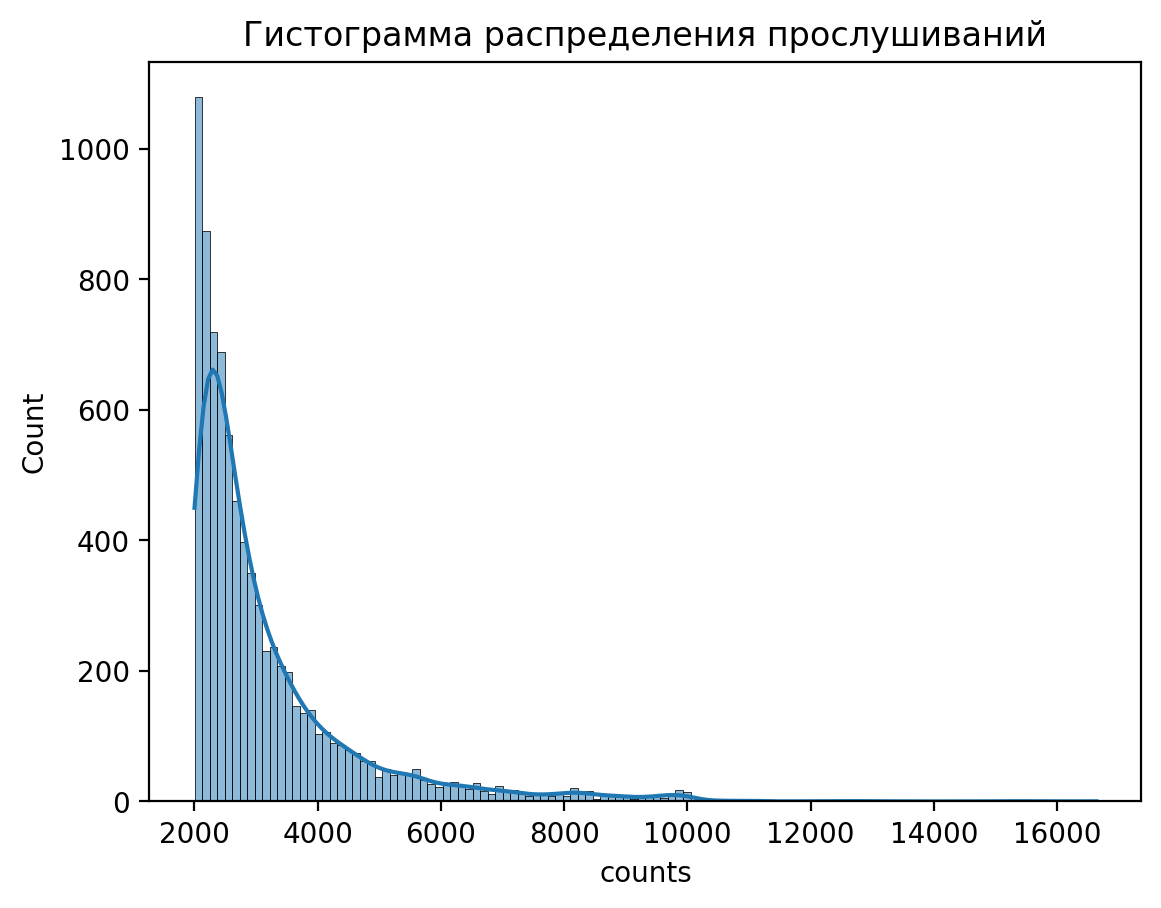

In [33]:
df = interactions_counts.query("counts > 2000").copy()
sns.histplot(data=df, x="counts", kde=True)
plt.title('Гистограмма распределения прослушиваний')
plt.show()

Наиболее популярные треки

In [42]:
top_tracks = interactions \
    .groupby(["track_id"]).agg(users=("user_id", "nunique")).reset_index()

top_k_pop_items = top_tracks.sort_values("users", ascending=False).head(100)

print(top_k_pop_items)

        track_id   users
9098       53404  111062
483876  33311009  106921
26665     178529  101924
512157  35505245   99490
829320  65851540   86670
...          ...     ...
146858   3616433   51416
64735     628970   50262
397743  27032843   50189
211580   9282507   49932
58616     560468   49832

[100 rows x 2 columns]


Наиболее популярные жанры

In [43]:
top_k_pop_items = top_k_pop_items.merge(tracks[["track_id", "genres"]], on="track_id", how="inner").sort_values("users", ascending=False).head(100)

print(top_k_pop_items)

    track_id   users         genres
0      53404  111062  [13, 14, 102]
1   33311009  106921      [14, 102]
2     178529  101924       [41, 47]
3   35505245   99490        [3, 75]
4   65851540   86670       [11, 20]
..       ...     ...            ...
95   3616433   51416           [11]
96    628970   50262           [13]
97  27032843   50189      [47, 308]
98   9282507   49932       [2, 102]
99    560468   49832       [2, 102]

[100 rows x 3 columns]


Треки, которые никто не прослушал

In [46]:
all_tracks = interactions \
    .merge(tracks, on="track_id", how="left") \
    .groupby(["track_id"]).agg(users=("user_id", "nunique")).reset_index()
    

zero_tracks = tracks[all_tracks["users"].isnull()]

print(zero_tracks)

Empty DataFrame
Columns: [track_id, albums, artists, genres]
Index: []


/tmp/ipykernel_26231/2825471877.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_tracks = tracks[all_tracks["users"].isnull()]


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [50]:
items = tracks.copy()
events = interactions.copy()

items = items.rename(columns={"track_id": "item_id"})
events = events.rename(columns={"track_id": "item_id"})

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [70]:
# s3_items_url = f"s3://{s3_bucket}/recsys/data/items.parquet"
# with fs.open(s3_items_url, 'w') as f:
#     items.to_parquet(f)

# s3_events_url = f"s3://{s3_bucket}/recsys/data/events.parquet"
# with fs.open(s3_events_url, 'w') as f:
#     events.to_parquet(f)

items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [72]:
del interactions
del tracks
del items
del events

# Следует перезапустить kernel и продолжить с запуска секций ниже

In [1]:
import logging
import os
import s3fs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [74]:
items = pd.read_parquet("items.parquet")

In [2]:
events = pd.read_parquet("events.parquet")

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [6]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16").to_datetime64()

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

# количество пользователей, которые есть и в train, и в test
common_users = users_test[users_test.isin(users_train)]

print(len(users_train), len(users_test), len(common_users))

1342566 783525 752870


In [7]:
events_train.to_parquet("events_train.parquet")
events_test.to_parquet("events_test.parquet")

# Топ популярных

Рассчитаем рекомендации как топ популярных.

# Персональные

Рассчитаем персональные рекомендации.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.